In [43]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sympy import *
import mtcnn
import cv2
from mtcnn.mtcnn import MTCNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
#Libraries to evaluate the face recognition system's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

### Part 1: Dataset Selection and Preprocessing (15 points)

#### Testing pre-processing and face detection on one file

Set the default image dimensions

In [44]:
nrows = 64
ncolumns = 64

Specify the directory with the Yale faces and non-faces

In [45]:
yalefaces_dir = 'yalefaces'
nonfaces_dir = 'non_faces'

#### Setup the dataset into training and testing data

Load the file data into different lists

In [46]:
subject_numbers = []
file_names = []
categories  = []
# Get the list of filenames
for file in os.listdir(yalefaces_dir):
    # Add the subject number, filename and category to seperate lists
    file_names.append(file)
    categories.append(file.split(".")[1])
    subject_numbers.append(file.split(".")[0].replace('subject0','').replace('subject',''))

Create a pandas DataFrame from the lists

In [47]:
faces_dict = {'Subject':subject_numbers, 'Category':categories, 'File':file_names}
faces_df = pd.DataFrame(faces_dict, columns = ['Subject', 'Category','File'])
faces_df.head()

,Subject,Category,File
0,1,centerlight,subject01.centerlight
1,1,glasses,subject01.glasses
2,1,happy,subject01.happy
3,1,leftlight,subject01.leftlight
4,1,noglasses,subject01.noglasses


Set the sizes of the test and training datasets

In [48]:
training_set_count = 8
class_count = len(faces_df["Subject"].unique())
dataset_size = faces_df["Category"].count()
test_size = 1 - (training_set_count * class_count / dataset_size)

Define the X and Y columns that will be used for testing and training

In [49]:
y = faces_df['Subject']
X = faces_df.drop('Subject', axis = 1)

X_train_info, X_test_info, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = 45, stratify = y)

Load the X_test and X_train data

In [50]:
def load_images_dataset(image_directory, dataset):
    face_images = []
    for filename in dataset["File"]:
        # Load the image from the directory as a PIL image
        image = Image.open(os.path.join(image_directory, filename))
        image = image.resize((nrows, ncolumns))
        face_images.append(np.asarray(image))
        
    return np.asarray(face_images)

In [51]:
X_test = load_images_dataset(yalefaces_dir, X_test_info)
X_train = load_images_dataset(yalefaces_dir, X_train_info)

Reshape and normalize the data

In [52]:
# Normalize the input vectors and labels
in_encoder = Normalizer(norm='l2')

# Reshape X_train into a 2D array using the dimensions of the 3D array
X_train_reshaped = X_train.reshape(X_train.shape[0],
                                   X_train.shape[1]*X_train.shape[2])
print('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)

# Reshape X_test into a 2D array using the dimensions of the 3D array
X_test_reshaped = X_test.reshape(X_test.shape[0],
                                 X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

#Normalize labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

Reshaped X_train (120, 4096)
Reshaped X_test (45, 4096)


LabelEncoder()

In [53]:
X_train.shape

(120, 64, 64)

### Part 2: Eigenface Generation (20 points)

Calculate the average face image

In [54]:
# Get the length of the images array
length_dataset = X_train_reshaped.shape[0]

mean_face = np.sum(X_train_reshaped, axis=0, dtype='float64') / length_dataset

Find the mean matrix using the numpy tile function. np.tile constructs an array by repeating a given dataset by the number of times specified

In [55]:
mean_matrix = np.tile(mean_face, (length_dataset, 1))

Mean-center the image data. Mean-centering calculates the difference between the mean value and the actual value, ensuring that we are only looking at the variance in the dataset

In [56]:
X_centered = X_train_reshaped - mean_matrix

Caclulate the co-variance in the data. Convariance is a measure of the relationship between two variables.

In this case, we calculate the co-variance by finding the dot product of the image data and a transposed version of the image data

In [57]:
covariance_matrix = (X_centered.dot(X_centered.T)) / length_dataset

Find the eigenvalues and eigenvectors using the covariance matrix. Because they are square and symmetrical, covariance matrixes are diagonalizable, which means an eigendecomposition can be performed on the matrix.

In [58]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

Convert the eigenvalues and eigenvectors from complex numbers to real numbers

In [59]:
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

Find the order of the eignevalues

In [60]:
order = np.real(eigenvalues).argsort()[::-1]

Sort the eigenvalues by their order

In [61]:
eigenvalues = eigenvalues[order]

Get the principal components

In [62]:
eigenvectors_C = eigenvectors[:, order]

Project all images to the eigen space

In [63]:
eigenvectors_C = X_centered.T @ eigenvectors 

Normalize all the eigenfaces

In [64]:
eigenfaces = preprocessing.normalize(eigenvectors_C.T)

Plot the first eigenface

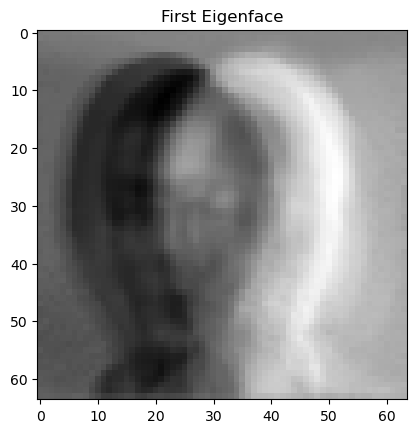

In [65]:
plt.imshow(np.resize(eigenfaces[0], (nrows,ncolumns)), cmap='gray')
plt.title('First Eigenface')
plt.show()

### Part 3: Face Recognition (35 points)

Get the recounstruction error to determine the initial number of components to use

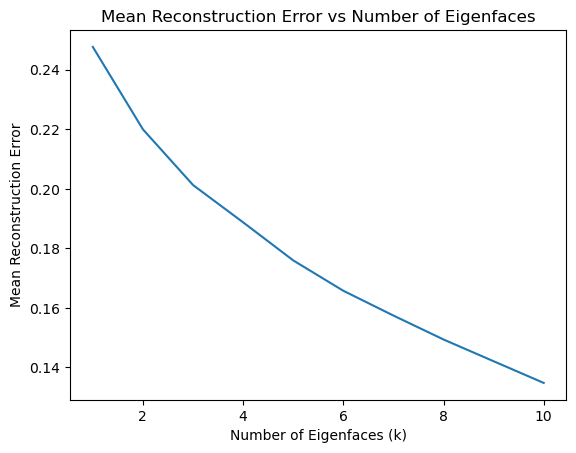

Mean reconstruction error using k=10: 0.13480881082497076


In [66]:
errors = []

for k in range(1, 11):
    error_sum = 0
    for F in X_train_reshaped:
        omega = eigenfaces[:k].dot(F - mean_face)
        F_reconstructed = eigenfaces[:k].T.dot(omega) + mean_face
        error = np.linalg.norm(F - F_reconstructed)
        error_sum += error
    mean_error = error_sum / X_train_reshaped.shape[0]
    errors.append(mean_error)

plt.plot(range(1, 11), errors)
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Mean Reconstruction Error')
plt.title('Mean Reconstruction Error vs Number of Eigenfaces')
plt.show()

print(f"Mean reconstruction error using k=10: {errors[9]}")

From the above graph we can deduce that 10 or Eigenfaces represent the same data, as the the mean reconstruction error reduces. Therefore, we will start with the number of components as 10, increase the count and get the performance for each increment

Create a function to project an image to the eigenspace

In [67]:
def project_to_eigenspace(image, eigen_faces, mean_face):
    return eigen_faces.dot(image - mean_face)

Create a function to find the cosine similarity between two matrices

In [68]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

Create a function to find the maximum similarity between an image projection and the set of eigen faces

In [69]:
def compute_max_similarity(image_projection, eigen_faces, num_components):
    eigen_projections = [project_to_eigenspace(ef, eigen_faces, mean_face) for ef in eigen_faces[:num_components]]
    similarities = [cosine_similarity(image_projection, ep) for ep in eigen_projections]
    
    return np.max(similarities)

Define a function to determine if an image contains a face

In [70]:
def is_face(image, eigen_faces, mean_face, num_components, threshold = 0.5):
    image_projection = project_to_eigenspace(image, eigen_faces, mean_face)
    max_similarity = compute_max_similarity(image_projection, eigen_faces[:num_components], num_components)
    return max_similarity > threshold

Check if an image is a face

In [71]:
given_image = Image.open('non_faces/B1_00002.pgm')
given_image = given_image.resize((nrows, ncolumns))
num_components = 10

# Convert the given image into a numpy array
given_image = np.asarray(given_image.getdata())

# Get the face evaluation result
result = is_face(given_image, eigenfaces[:num_components], mean_face, num_components)
if result:
    print("The image is a face")
else:
    print("The image is not a face")

The image is not a face


Check the difference between the actual mean face and predicted mean faces

In [72]:
true_label = []
predicted_label = []

In [73]:
# Loop through the faces
for i, image_file in enumerate(os.listdir(yalefaces_dir)):
    # Label the file as a face
    true_label.append(1)
    new_image = Image.open(os.path.join(yalefaces_dir, image_file))
    new_image = new_image.resize((nrows, ncolumns))
    new_image = np.asarray(new_image.getdata())
    
    if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
        predicted_label.append(1)
    else:
        predicted_label.append(0)

In [74]:
# Loop through the non-faces
for i, image_file in enumerate(os.listdir(nonfaces_dir)):
    # Label the file as a face
    true_label.append(0)
    new_image = Image.open(os.path.join(nonfaces_dir, image_file))
    new_image = new_image.resize((nrows, ncolumns))
    new_image = np.asarray(new_image.getdata())
    
    if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
        predicted_label.append(1)
    else:
        predicted_label.append(0)

Print the evaluation metrics

In [75]:
score = accuracy_score(true_label, predicted_label)
precision = precision_score(true_label, predicted_label)
recall = recall_score(true_label, predicted_label)
f1 = f1_score(true_label, predicted_label)
print(f"Accuracy score is {score}")
print(f"Precision score is {precision}")
print(f"Recall score is {recall}")
print(f"F1 score is {f1}")

Accuracy score is 0.6706586826347305
Precision score is 0.0
Recall score is 0.0
F1 score is 0.0


C:\Users\Sama\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part 4: Experimentation and Analysis (20 points)

Define a function to calculate the accuracy with a varying number of components using the logic defined above

In [76]:
def get_accuracy_score(num_components, faces_directory, non_faces_directory):
    # Loop through the faces
    for i, image_file in enumerate(os.listdir(faces_directory)):
        # Label the file as a face
        true_label.append(1)
        new_image = Image.open(os.path.join(faces_directory, image_file))
        new_image = new_image.resize((nrows, ncolumns))
        new_image = np.asarray(new_image.getdata())

        if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
            predicted_label.append(1)
        else:
            predicted_label.append(0)
        
    # Loop through the non-faces
    for i, image_file in enumerate(os.listdir(non_faces_directory)):
        # Label the file as a face
        true_label.append(0)
        new_image = Image.open(os.path.join(non_faces_directory, image_file))
        new_image = new_image.resize((nrows, ncolumns))
        new_image = np.asarray(new_image.getdata())

        if is_face(new_image, eigenfaces[:num_components], mean_face, num_components):
            predicted_label.append(1)
        else:
            predicted_label.append(0)
            
    #Compute the accuracy, precision, recall and F1 scores
    score = accuracy_score(true_label, predicted_label)
    precision = precision_score(true_label, predicted_label)
    recall = recall_score(true_label, predicted_label)
    f1 = f1_score(true_label, predicted_label)
    # Return the four computed metrics
    return score, precision, recall, f1     

Create a loop that checks the accuracy for an increasing number of components

In [ ]:
# Create lists to hold the metrics
evaluation_scores = []
for num_components in range(1, 70, 5):
    score, precision, recall, f1 = get_accuracy_score(num_components, yalefaces_dir, nonfaces_dir)
    evaluation_scores.append([num_components, score, precision, recall, f1])

Print the results in a table

In [ ]:
table = evaluation_scores
print(tabulate(table, headers=["Number of Components", "Accuracy Score", "Precision Score", "Recall Score", "F1 Score"]))

**Conclusion**

In [ ]:
diff = 0.633763 - 0.612679
round(diff, 4)

As the number of components of components increases, the accuracy of the model only shows slight increment. For example with 26 components, the accuracy score is 0.612679 while with 86 components, the accuracy is 0.633763. The difference in accuracy score between using 26 and 86 components is approximately 0.0211. 

Therefore, we can conclude that the number of components increases, the algorithm has already extracted the most relevant information from the faces with the initial set of features and the new images being added are not adding more information to the algorithm

We can also conclude that the model will perform as well when using the initial number of components which was 5